## ROUND 1

### Verifier(classical)  

This code snippet generates 2 random prime numbers p and q such that p and q are congruent to 3mod4.It returns N=pq and trapdoor secret data (p,q).

In [10]:
from classiq import*
import sympy as sy


p=sy.randprime(2,12)  
q=sy.randprime(2,12)

def get_prime():
    while True:
        p=sy.randprime(2,12)
        q=sy.randprime(2,12)
        if p%4==3 and q%4==3:
            N=p*q
            return N,(p,q)
f=get_prime()
f
N1=f[0]
p1=f[1][0]
q1=f[1][1]
N1,p1,q1

(21, 7, 3)

### Prover(Quantum)

 2 codes are given for creating a quantum circuit for 3 qubit state using several CNOT,CCNOT and MCX gates to calculate the given equation.<br>
 
 $$x^2 \mod N$$
 
 
In code 1,the modular operation is done by quantum circuit itself whereas in code 2, quantum circuit does multiplication operation.Then modular operation is acheived classically.

In both codes,the x register encodes numbers from 0 to 7 in superposition and y register outputs all their squares in superposition.<br>



*Note:Code 1 is restricted only for modulo power of 2 but circuit in 2nd code can use N of any value with slight tweaking of code.

## CODE 1

In [ ]:
N=8

from classiq import *
import numpy as np

@qfunc
def callin(l:QBit, m:QBit, k:QBit)-> None:
    
    ctrl=QArray("ctrl")
    
    bind([l,m],ctrl)
    CCX(ctrl,k)
    bind(ctrl,[l,m])

@qfunc
def arithmetic(x1:QArray[QBit], y1:QArray[QBit])-> None:
    
    CX(x1[2],y1[4])
    CX(x1[1],y1[2])
    CX(x1[0],y1[0])
              
    callin(x1[1],x1[2],y1[4])
              
    callin(x1[1],x1[2],y1[5])
              
    callin(x1[0],x1[1],y1[2])
              
    callin(x1[0],x1[1],y1[3])
              
    callin(x1[0],x1[2],y1[3])
              
              
    control(ctrl= x1, stmt_block=lambda: X(y1[4]))
    
    
    
    
@qfunc
def main(x:Output[QNum], y:Output[QNum], res:Output[QNum])-> None:
    
    allocate(3,x)
    allocate(6,y)
    
    hadamard_transform(x)
    arithmetic(x,y)
    
    res|= (y)%N
    
    
    
qmod = create_model(main)
quantum_program = synthesize(qmod)
show(quantum_program)
results = execute(quantum_program).result()
res = results[0].value.parsed_states
x_y_res = [value for value in res.values()]
x_y_res
for i in range(len(x_y_res)):
    res_values = [item['res'] for item in x_y_res]
print('x^2modN values:',res_values)        

In [43]:
import matplotlib.pyplot as plt

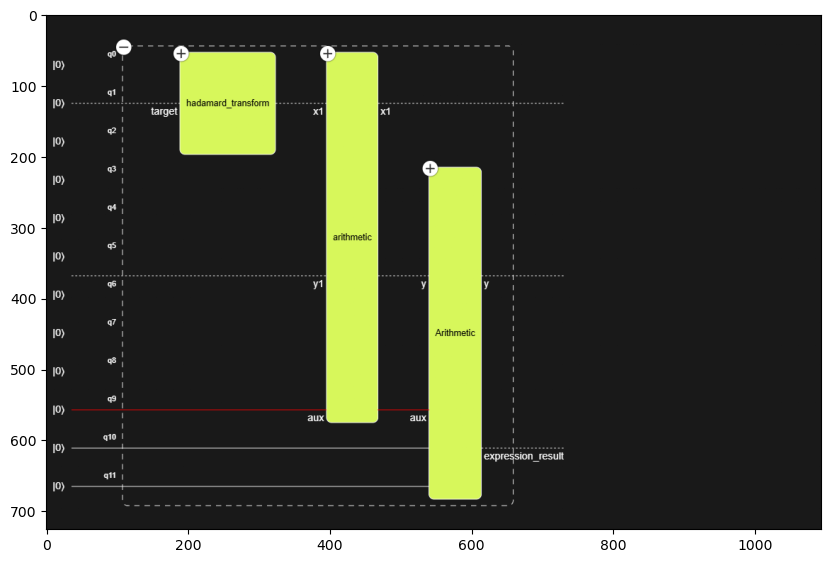

In [47]:
plt.figure(figsize=(10,10))
img1=plt.imread('x2modNfirst.jpg')
plt.imshow(img1)

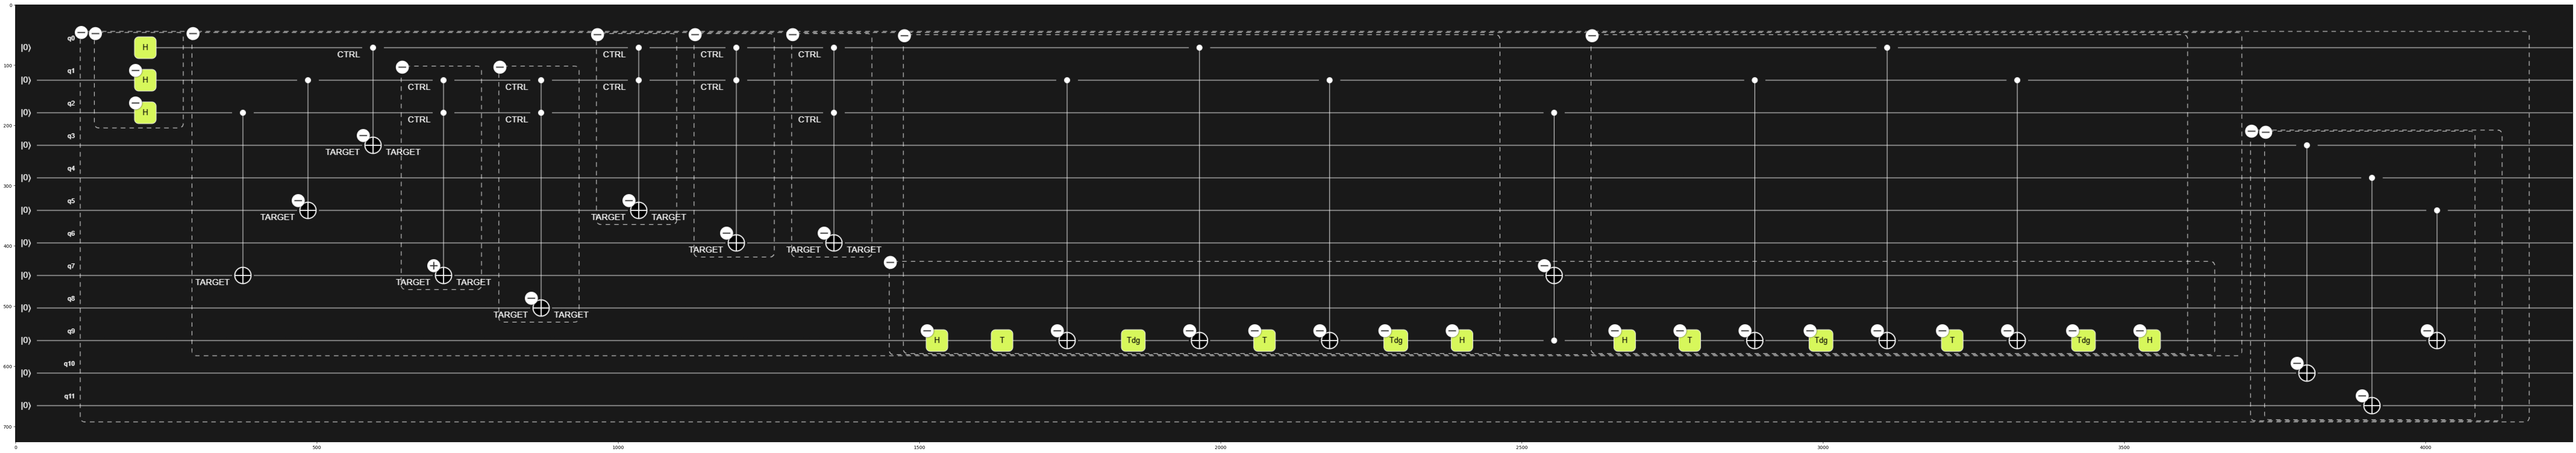

In [49]:
plt.figure(figsize=(100,100))
img2=plt.imread('x2modNfirst2.jpg')
plt.imshow(img2)

## CODE 2

In [90]:
import math
N=21
s= math.floor((1/N)*10000)

from classiq import *
import numpy as np
from classiq.execution import ExecutionPreferences

@qfunc
def callin(l:QBit, m:QBit, k:QBit)-> None:
    
    ctrl=QArray("ctrl")
    
    bind([l,m],ctrl)
    CCX(ctrl,k)
    bind(ctrl,[l,m])

@qfunc
def arithmetic(x1:QArray[QBit], y1:QArray[QBit])-> None:
    
    CX(x1[2],y1[4])
    CX(x1[1],y1[2])
    CX(x1[0],y1[0])
              
    callin(x1[1],x1[2],y1[4])
              
    callin(x1[1],x1[2],y1[5])
              
    callin(x1[0],x1[1],y1[2])
              
    callin(x1[0],x1[1],y1[3])
              
    callin(x1[0],x1[2],y1[3])
              
              
    control(ctrl= x1, stmt_block=lambda: X(y1[4]))
    
    
    
    
@qfunc
def main(x:Output[QNum], y:Output[QNum], res:Output[QNum])-> None:
    
    allocate(3,x)
    allocate(6,y)
    
    hadamard_transform(x)
    arithmetic(x,y)
    
    res|= (y)*s
    
    
    
qmod = create_model(main)
execution_preference=set_execution_preferences(
    qmod,
    ExecutionPreferences(
        num_shots=1,
    ),)
quantum_program=synthesize(execution_preference)
#show(quantum_program)
results = execute(quantum_program).result()
res = results[0].value.parsed_states
x_y_res = [value for value in res.values()]
x_y_res
for i in range(len(x_y_res)):
    res_values = [item['res'] for item in x_y_res]
res_values        

[7616.0]

In [92]:
write_qmod(qmod,'Round 1 code 1')

In [91]:
multiplied_list1=[x/10000 for x in res_values]
multiplied_list2 = [((x-(math.floor(x)))*N) for x in multiplied_list1 ]   
multiplied_list3=[round(x) for x in multiplied_list2]#round might change to math.floor in some cases.
print('x^modN values:',multiplied_list3)

x^modN values: [16]


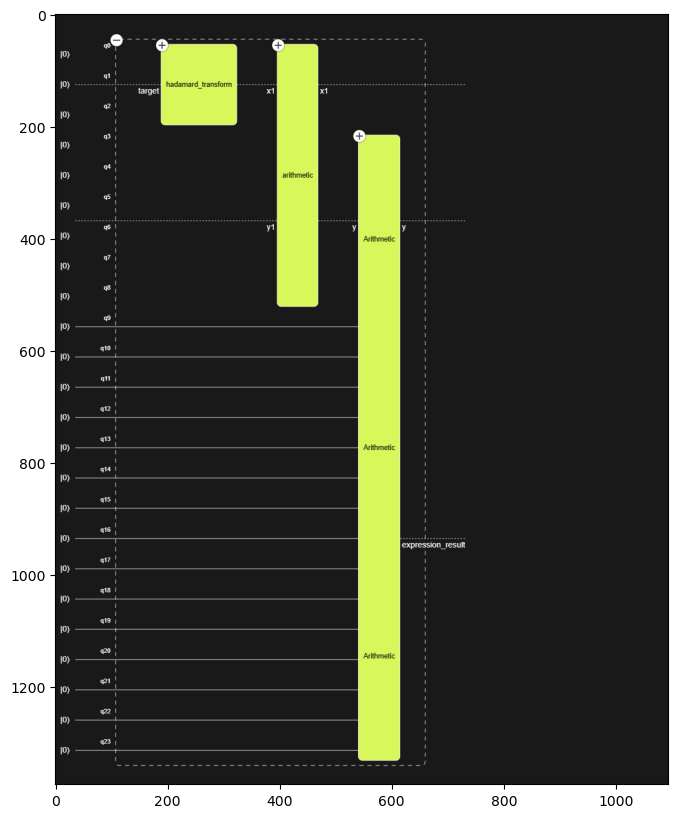

In [50]:
plt.figure(figsize=(10,10))
img3=plt.imread('x2modNsecond.jpg')
plt.imshow(img3)

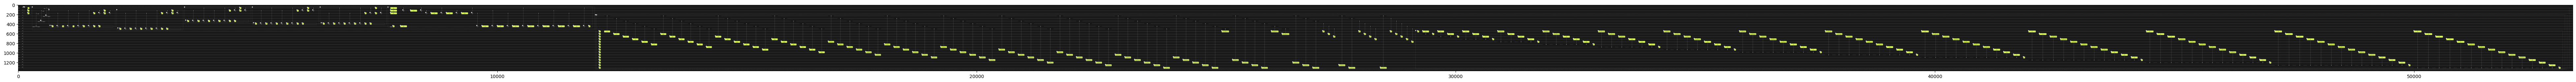

In [53]:
plt.figure(figsize=(100,100))
img4=plt.imread('x2modNsecond2.jpg')
plt.imshow(img4)

### Verifier

In this code block, using N,c which is the output of x^2modN,and secret trapdoor data p,q we find 

the roots of x^2 mod N which are the possible values of x using Rabin's Decryption method.

Since we run the above circuit for only one shot we get one particular value of x^2modN.This is our y value,this can be considered equivalent to measuring just the y register.So that its value collapse to 1 single x^2modN value.


c=(x**2)%N1,this is the equation for generating ciphertext in rabins function,here the value that we got from quantum circuit above corresponds to this c value.So we can use the rabin's function decryption algorithm and compute corresponding x values using this c and the trapdoor data p,q and the N value.

This would be last step of verifier in round 1.


#### Circuit Limitation

Since our quantum circuit can only generate numbers upto 7,among the two values that we can find for x using rabin's Decryption method(originally there would be 4 values of x since we limit the domain to N/2 there will be only 2 values) we can only find only one x value here.

In [17]:
c=16
def extended_gcd(a, b):
    if b == 0:
        return 1, 0
    else:
        x1, y1 = extended_gcd(b, a % b)
        yp = y1
        yq = x1 - (a // b) * y1
        return yp, yq

def rabins_decryption(p,q,N,c):
    mp=(c**((p+1)/4))%p
    mq=(c**((q+1)/4))%q
    yp,yq=extended_gcd(p,q)
    r1=((yp*p*mq)+(yq*q*mp))%N
    r2=N-r1
    r3=((yp*p*mq)-(yq*q*mp))%N
    r4=N-r3
    return(r1,r2,r3,r4)
    
    

rabins_decryption(p1,q1,N1,c)

(4.0, 17.0, 10.0, 11.0)

Now the verifier can request for a measurement of x register.Since we got x^2modN as 16 we can intuitively understand that our x value is 4.Since we can't measure the already measured circuit in classiq SDK,we can compare the output of rabins decryption algorithm with our intuitive knowledge and understand that prover would measure exactly the values outputed by the Rabin's Decryption method.

## ROUND 2

### Prover

This is a code for generating bitwise inner product r.x where r is the random bit number which can be generated by below code.Then we apply CNOT gates to an ancilla qubit keeping controls in the bit of a quantum register 'a' corresponding to the bits which are 1 in the random bitstring 'r'.Thus we create the bitwise inner product in the ancilla qubit.

In [41]:
import random
r=random.randint(16,32)
bits=bin(r)[2:]
bits

'11011'

In [68]:
from classiq import *
import numpy as np


@qfunc
def main(a:Output[QArray[QBit]], anc:Output[QBit] )-> None:
    
    allocate(5,a)
    allocate(1,anc)
    #------------------------------
    hadamard_transform(a[4])# These gates create a superposition of 4 and 17
    CX(a[4],a[0])           
    X(a[2])
    CX(a[4],a[2])
    #------------------------------
    CX(a[4],anc)#These Gates implement bitwise inner product
    CX(a[3],anc)
    CX(a[1],anc)
    CX(a[0],anc)
    
qmod=create_model(main)  
qprog=synthesize(qmod)
show(qprog)
results = execute(qprog).result()
res = results[0].value.counts
res1 = results[0].value.parsed_counts


total_shots = sum(res.values())
individual_shots = [value for value in res.values()]


probabilities=[]
for i in range(len(individual_shots)):
    probabilities.append((individual_shots[i])/total_shots)
print(res1)
probabilities#The given probabilities are of 'a' register.The ancilla qubit is 0 in both case.

[{'a': [1, 0, 0, 0, 1], 'anc': 0.0}: 1035, {'a': [0, 0, 1, 0, 0], 'anc': 0.0}: 1013]


[0.49462890625, 0.50537109375]

In [70]:
write_qmod(qmod,'Round 2')

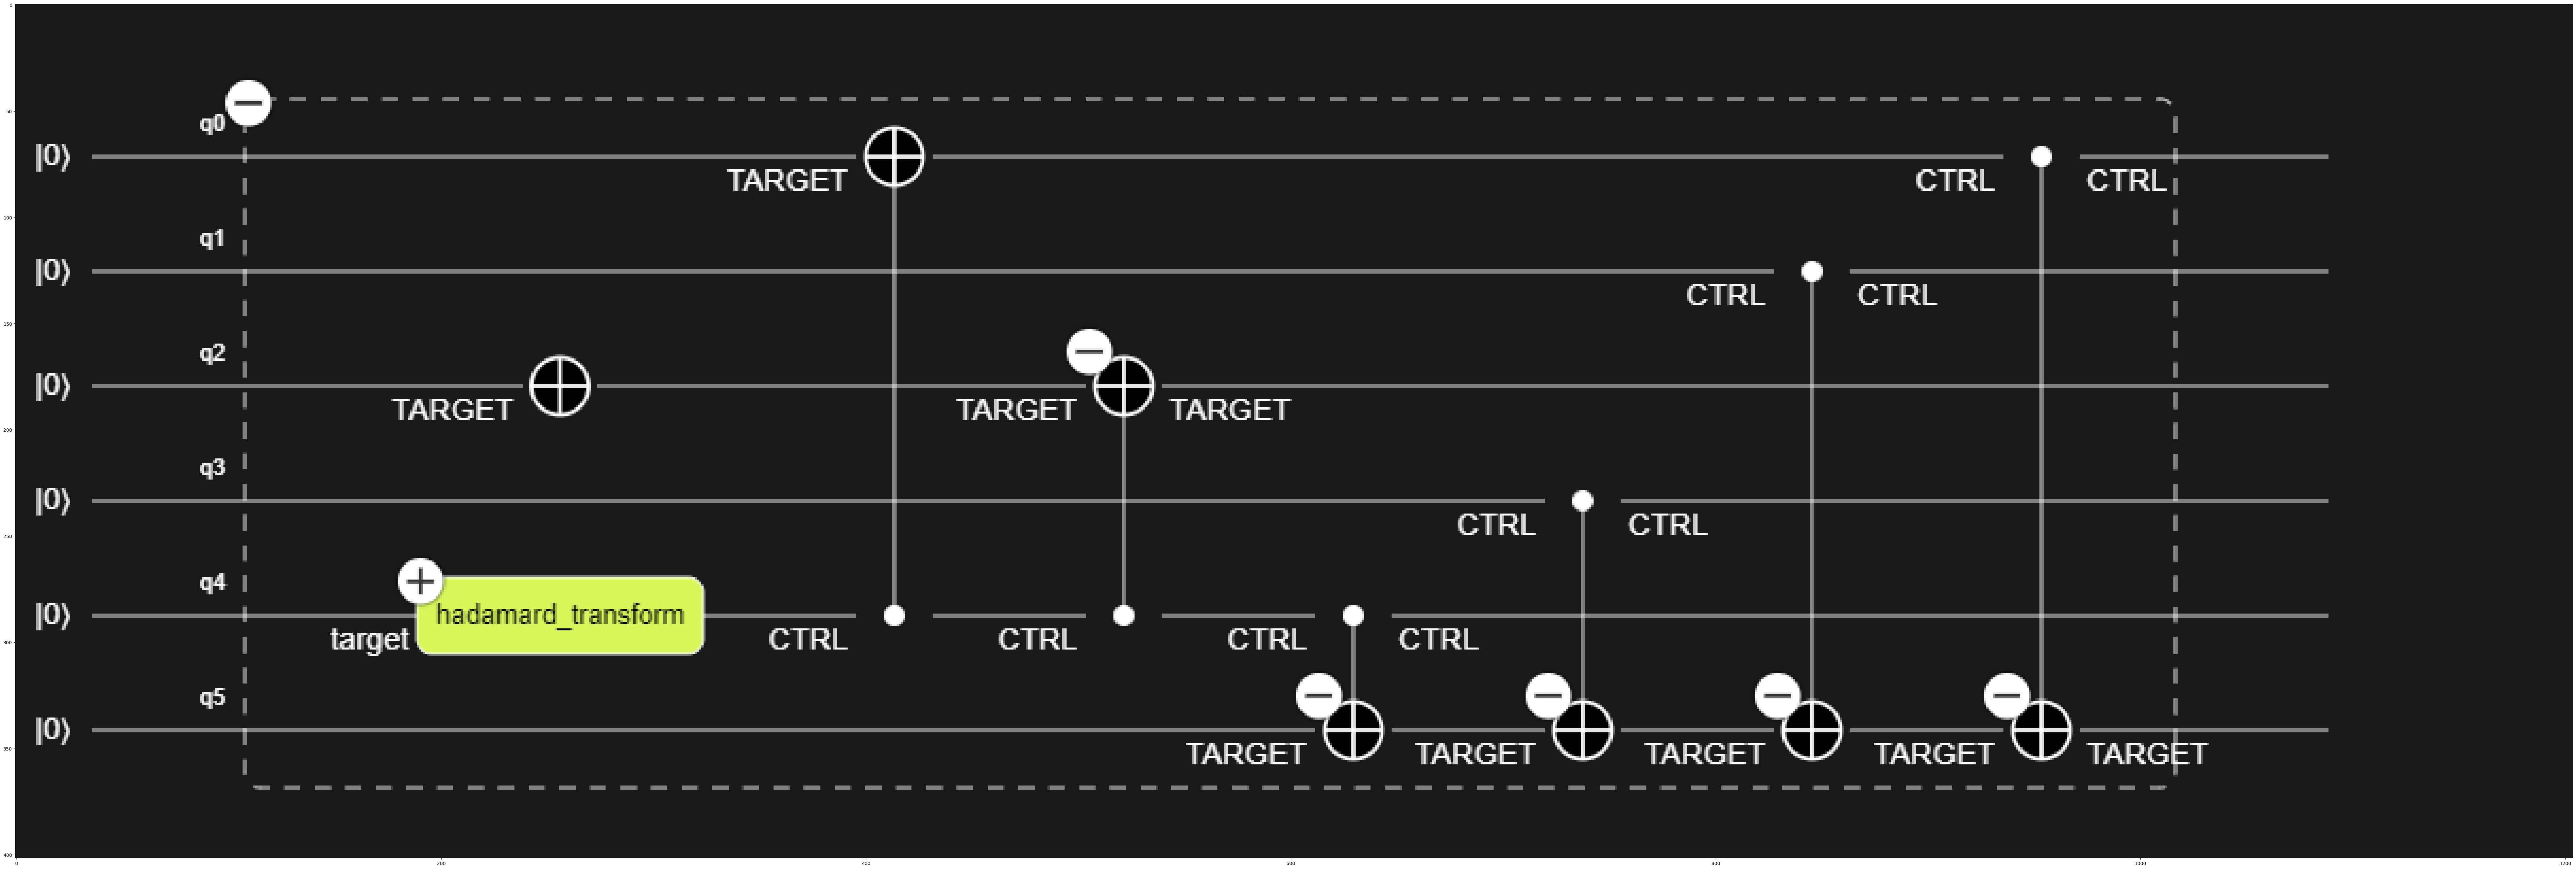

In [56]:
plt.figure(figsize=(100,100))
img5=plt.imread('Round 2.jpg')
plt.imshow(img5)

Here we got an output of bitwise inner product 4 (00100) and 17(10001) with random bitstring 11011.Both are equal to 0.We can try with other values and see that the output of ancilla can be both 0 , both 1 or a superposition of 0 and 1.

We chose  the 'a' register as a superposition of 4 and 17.Since both are the roots we got for x^2mod21.But we only got the value 4 from the quantum circuit since it was implemented for 3 qubits.


Since dual measurements are not possible we take the value of x corresponding to the y we measured earlier.So we take x0=4 and x1=17 and d=4 and r=11011.Note that d would be the value obtained from 
measurement of x register and x0 and x1 are obtained from rabins decryption algorithm

### Verifier 

In [59]:
d=[0,0,1,0,0]
x1=[1,0,0,0,1]
x0=[0,0,1,0,0]
r_rand=[1,1,0,1,1]

def innerproduct(x,r):
    list1=[]
    for i in range(len(r)):
        list1.append(x[i]*r[i])
    g=sum(list1)%2  
    return g

print('inner product of x0 and random bit:',innerproduct(x0,r_rand))
print('inner product of x1 and random bit:',innerproduct(x1,r_rand))
print('inner product of d and random bit:',innerproduct(d,r_rand))

inner product of x0 and random bit: 0
inner product of x1 and random bit: 0
inner product of d and random bit: 0


From this we get both r.x0 and r.x1 are 0.From this we can classically verify the state of ancilla qubit after x register was measured.

## ROUND 3

### Prover

In this circuit we just add the RY gate to rotate the basis of measurement of ancilla qubit

#### CODE 1

In [74]:
from classiq import *
import numpy as np


@qfunc
def main(a:Output[QArray[QBit]], anc:Output[QBit] )-> None:
    
    allocate(5,a)
    allocate(1,anc)
    hadamard_transform(a[4])# These gates create a superposition of 4 and 17
    CX(a[4],a[0])           
    X(a[2])
    CX(a[4],a[2])
    
    CX(a[4],anc)
    CX(a[3],anc)
    CX(a[1],anc)
    CX(a[0],anc)
   
    RY(np.pi/4,anc)
    


qmod=create_model(main)


qprog=synthesize(qmod)
#show(qprog)
results = execute(qprog).result()
res = results[0].value.counts
res1 = results[0].value.parsed_counts


total_shots = sum(res.values())
individual_shots = [value for value in res.values()]


probabilities=[]
for i in range(len(individual_shots)):
    probabilities.append((individual_shots[i])/total_shots)
print(res1)
probabilities

[{'a': [1, 0, 0, 0, 1], 'anc': 0.0}: 909, {'a': [0, 0, 1, 0, 0], 'anc': 0.0}: 809, {'a': [0, 0, 1, 0, 0], 'anc': 1.0}: 180, {'a': [1, 0, 0, 0, 1], 'anc': 1.0}: 150]


[0.087890625, 0.0732421875, 0.39501953125, 0.44384765625]

In [71]:
write_qmod(qmod,'Round 3 code 1')

From the output,we can see that two probabilities are much higher than the other two and they correspond to the correct values of r.x which is 0.Combining these two probabilities we can understand that the probability of getting the correct r.x value is roughly 0.85.

In [77]:
probabilities[3]+probabilities[2]

0.8388671875

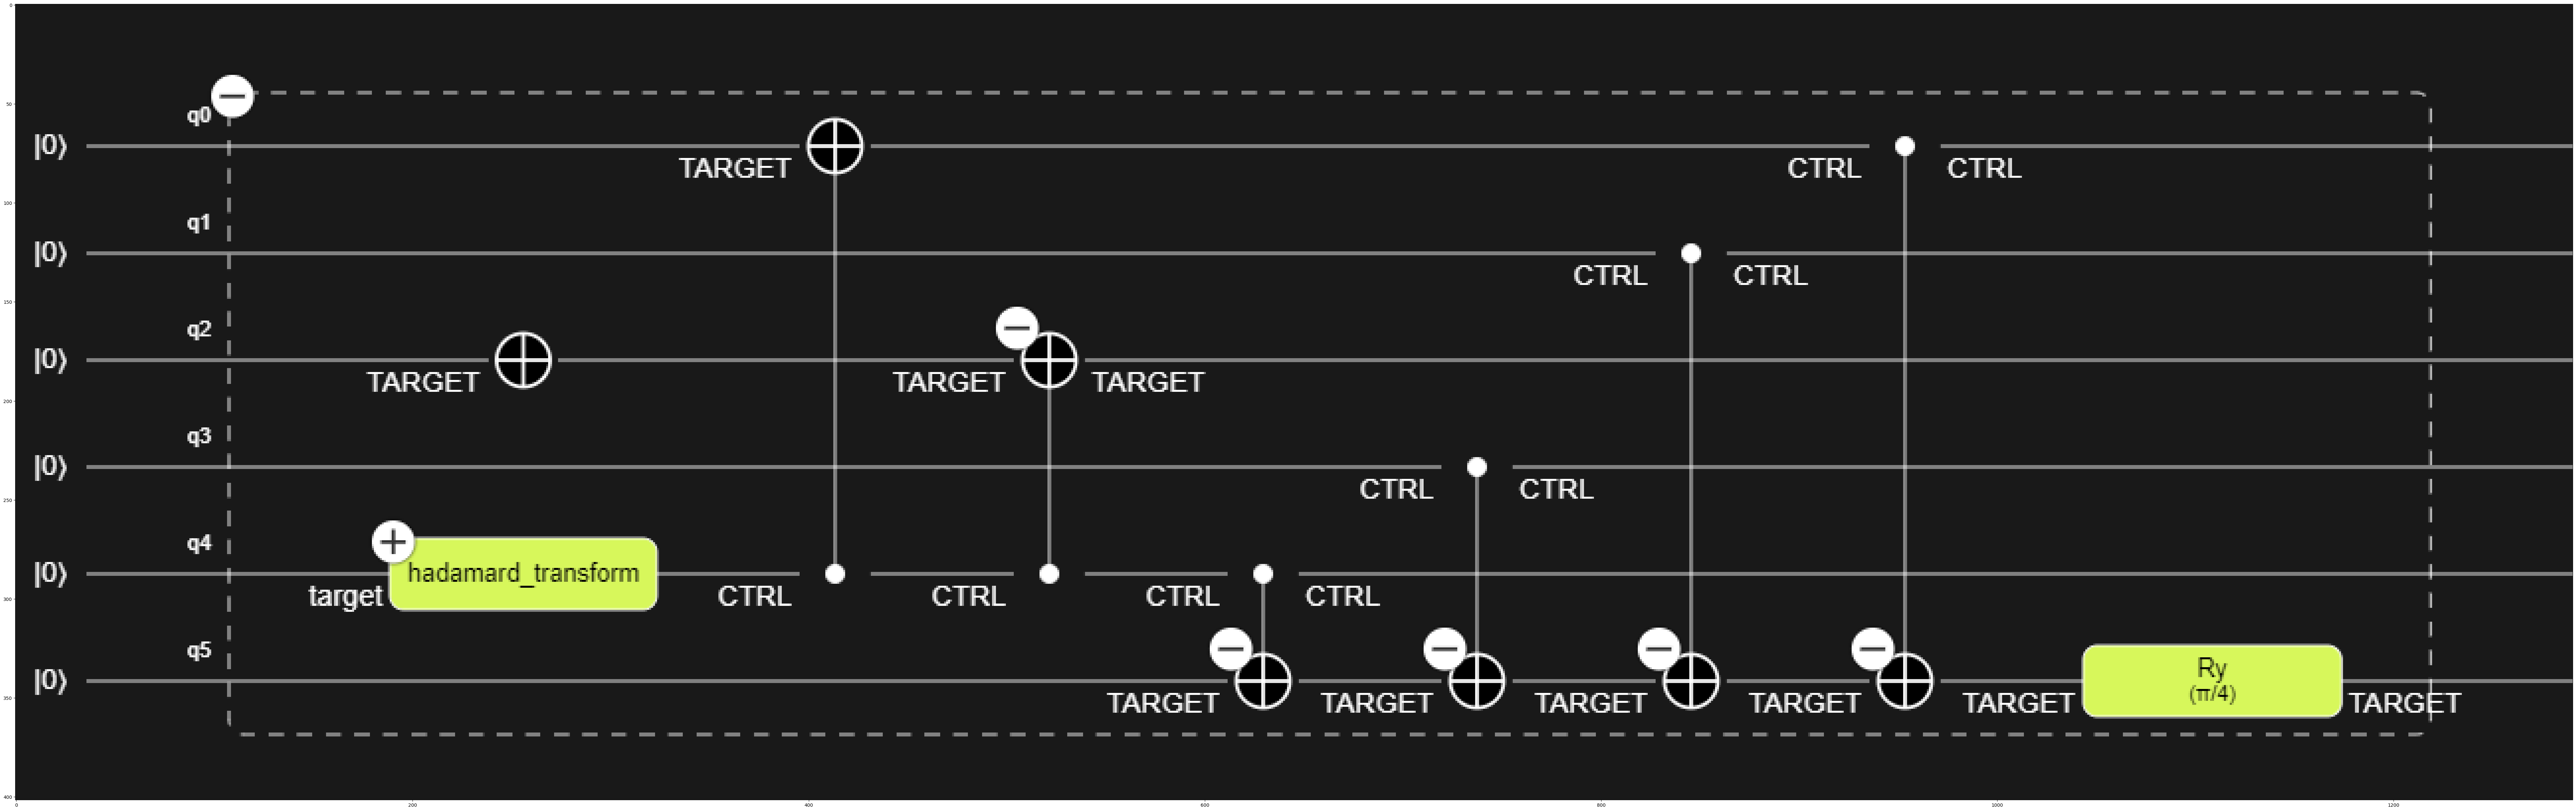

In [65]:
plt.figure(figsize=(100,100))
img6=plt.imread('round 3 code 1.jpg')
plt.imshow(img6)

The above circuit was for a superposition of 2 numbers taking inner product with a random bitstring.

The below circuit is for a single x value taking inner product with random bitstring.

#### CODE 2

In [78]:
from classiq import *
import numpy as np


@qfunc
def main(a:Output[QArray[QBit]], anc:Output[QBit] )-> None:
    
    allocate(5,a)
    allocate(1,anc)
    X(a[2])
    
    CX(a[4],anc)
    CX(a[3],anc)
    CX(a[1],anc)
    CX(a[0],anc)
    
    RY(np.pi/4 , anc)


qmod = create_model(main)
quantum_program = synthesize(qmod)
#show(quantum_program)
results = execute(quantum_program).result()
res = results[0].value.counts
res1 = results[0].value.parsed_counts


total_shots = sum(res.values())
individual_shots = [value for value in res.values()]


probabilities=[]
for i in range(len(individual_shots)):
    probabilities.append((individual_shots[i])/total_shots)
print(res1)
probabilities

[{'a': [0, 0, 1, 0, 0], 'anc': 0.0}: 1731, {'a': [0, 0, 1, 0, 0], 'anc': 1.0}: 317]


[0.15478515625, 0.84521484375]

Here also for the correct answer we got  roughly 0.85 probability.This demonstrate the "quantum advantage"

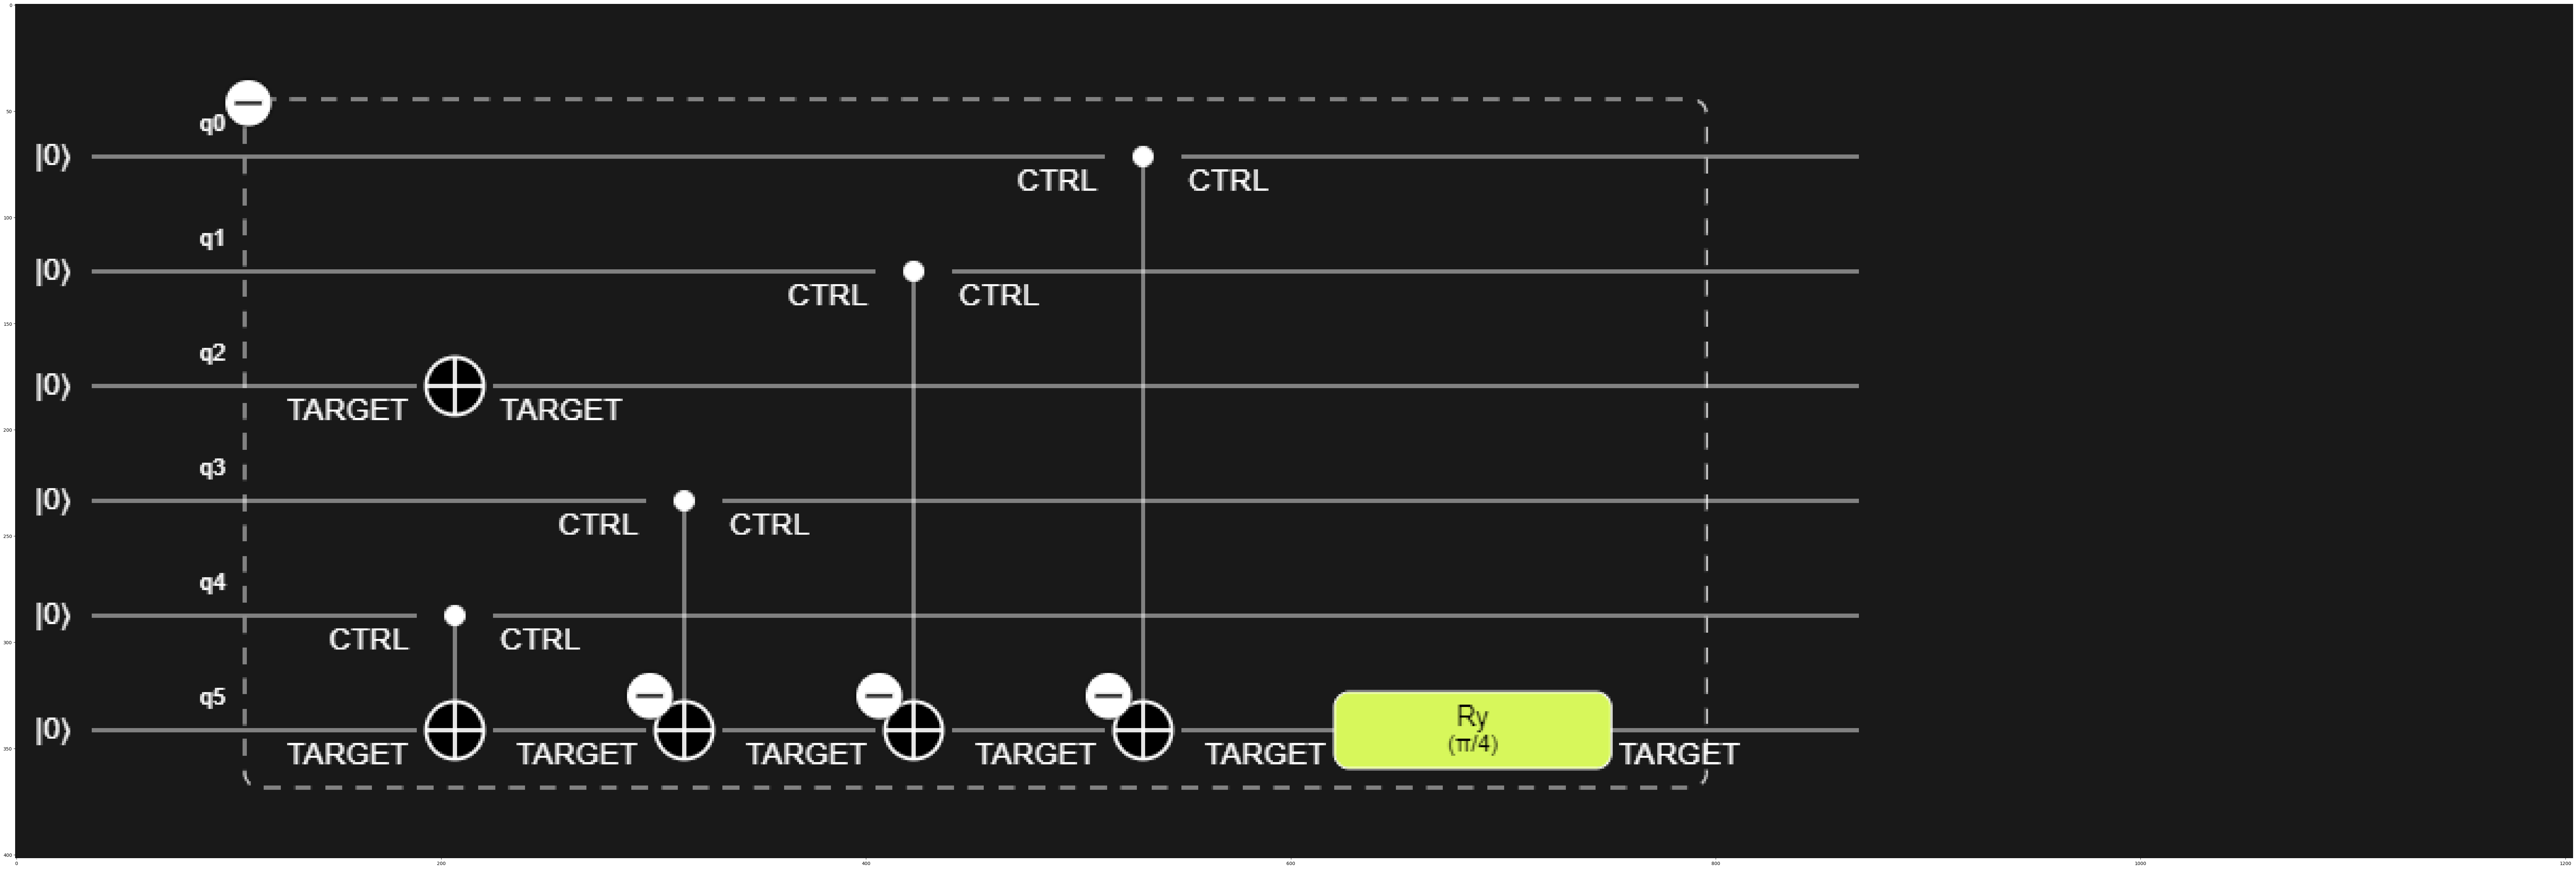

In [67]:
plt.figure(figsize=(100,100))
img7=plt.imread('round 3 code 2.jpg')
plt.imshow(img7)

In [81]:
write_qmod(qmod,"round 3 code 2")

### Main References
1.) [Classically verifiable quantum advantage from
a computational Bell test](https://doi.org/10.1038/s41567-022-01643-7)


2.) [(Supplementary material)Classically verifiable quantum advantage from
a computational Bell test](https://doi.org/10.1038/s41567-022-01643-7)

3.)Extended_gcd function adapted from [Geeks for Geeks](https://www.geeksforgeeks.org/euclidean-algorithms-basic-and-extended/)


4.) Rabin's function inspired from  [Rabins Function](https://en.wikipedia.org/wiki/Rabin_cryptosystem)

5.)Classiq Documentation and support team in slack.


6.)Explanations and guidance provided by ChatGPT and Copilot AI.